## 4.3. 컴퓨터 비전

### 4.3.1. 합성곱 신경망

In [1]:
import MLDatasets
import Flux, NNlib
using Flux: onehotbatch
using MLUtils: DataLoader
using CUDA: has_cuda
import Zygote, Optimisers
using Formatting: printfmtln
using Random: MersenneTwister
import Plots
# 필요 데이터 자동 다운로드
ENV["DATADEPS_ALWAYS_ACCEPT"] = true

true

패션 아이템 분류

4.2.절과 공통 코드

In [2]:
function get_data(batchsize = 64)
    xtrain, ytrain = MLDatasets.FashionMNIST(:train)[:]
    xtest, ytest = MLDatasets.FashionMNIST(:test)[:]

    xtrain = reshape(xtrain, 28, 28, 1, :)
    xtest = reshape(xtest, 28, 28, 1, :)

    ytrain, ytest = onehotbatch(ytrain, 0:9), onehotbatch(ytest, 0:9)

    train_loader = DataLoader((xtrain, ytrain), batchsize=batchsize)
    test_loader = DataLoader((xtest, ytest),  batchsize=batchsize)
    
    return train_loader, test_loader
end

function train(loader, model, loss_fn, optimizer)
    num_batches = length(loader)
    losses = Float32[]
    Flux.testmode!(model, false)
    for (batch, (X, y)) in enumerate(loader)
        X, y = Flux.gpu(X), Flux.gpu(y)
        grad = Zygote.gradient(m -> loss_fn(m, X, y), model)[1]
        optimizer, model = Optimisers.update(optimizer, model, grad)
        if batch % 300 == 0
            loss = loss_fn(model, X, y)
            printfmtln("[Train] loss: {:.7f} [{:>3d}/{:>3d}]", 
                loss, batch, num_batches)
            push!(losses, loss)
        end
    end
    model, optimizer, losses
end

function test(loader, model, loss_fn)
    num_batches = length(loader)
    Flux.testmode!(model, true)
    acc, tot = 0, 0
    loss = 0f0
    for (X, y) in loader
        X, y = Flux.gpu(X), Flux.gpu(y)
        pred = model(X)
        acc += sum(Flux.onecold(pred) .== Flux.onecold(y))
        tot += size(X)[end]
        loss += loss_fn(model, X, y)
    end
    acc, avg_loss = acc / tot * 100, loss / num_batches
    printfmtln("[Test] Accuracy: {:.1f}, Avg loss: {:.7f}", 
        acc, avg_loss)
    acc, avg_loss
end

init(rng) = Flux.glorot_uniform(rng)

function build_mlp_model(rng)
    Flux.Chain(
        Flux.flatten,
        Flux.Dense(28 * 28 => 512, NNlib.relu; init=init(rng)),
        Flux.Dense(512 => 512, NNlib.relu; init=init(rng)),
        Flux.Dense(512 => 10; init=init(rng)),
    )
end

build_mlp_model (generic function with 1 method)

간단한 합성곱 신경망 모델

In [3]:
function build_cnn_model(rng)
    same = Flux.SamePad()
    Flux.Chain(
        Flux.Conv((3,3),  1 => 32, NNlib.relu, pad=same; init=init(rng)),
        Flux.MaxPool((2,2)), # (28 x 28) => (14 x 14)
        Flux.Conv((3,3), 32 => 64, NNlib.relu, pad=same; init=init(rng)),
        Flux.MaxPool((2,2)), # (14 x 14) => (7 x 7)
        Flux.Conv((3,3), 64 => 64, NNlib.relu, pad=same; init=init(rng)),
        Flux.MaxPool((2,2)), # (7 x 7) => (3 x 3)
        Flux.flatten,
        Flux.Dense(3 * 3 * 64 => 64, NNlib.relu; init=init(rng)),
        Flux.Dense(64 => 10; init=init(rng)),
    )
end

build_cnn_model (generic function with 1 method)

합성곱 + 드랍아웃 + 배치 정규화

In [4]:
function build_cnn2_model(rng)
    same = Flux.SamePad()
    Flux.Chain(
        Flux.Conv((3,3),  1 => 32, NNlib.relu, pad=same; init=init(rng)),
        Flux.MaxPool((2,2)), # (28 x 28) => (14 x 14)
        Flux.Dropout(0.2),
        Flux.BatchNorm(32),

        Flux.Conv((3,3), 32 => 64, NNlib.relu, pad=same; init=init(rng)),
        Flux.MaxPool((2,2)), # (14 x 14) => (7 x 7)
        Flux.Dropout(0.2),
        Flux.BatchNorm(64),
        
        Flux.Conv((3,3), 64 => 64, NNlib.relu, pad=same; init=init(rng)),
        Flux.MaxPool((2,2)), # (7 x 7) => (3 x 3)        
        Flux.Dropout(0.2),
        Flux.BatchNorm(64),
        
        Flux.flatten,
        Flux.Dense(3 * 3 * 64 => 64, NNlib.relu; init=init(rng)),    
        Flux.Dropout(0.2),
        Flux.Dense(64 => 10; init=init(rng)),
    )
end

build_cnn2_model (generic function with 1 method)

복수 모델 일괄 실행

In [5]:
function run_batch(loaders, models, epochs)
    train_loader, test_loader = loaders
    loss_fn(m, x, y) = Flux.Losses.logitcrossentropy(m(x), y)
    train_losses, accuracies = [], []
    for (k, model) in enumerate(models)
        train_loss, accuracy = [], []
        optimizer = Optimisers.setup(Optimisers.Adam(), model)
        for t in 1:epochs
            println("[Model $k] Epoch $t")
            println("-------------------------------")
            model, optimizer, losses = train(train_loader, model, loss_fn, optimizer)
            train_loss = vcat(train_loss, losses)
            acc, _ = test(test_loader, model, loss_fn)
            push!(accuracy, acc)
        end
        push!(train_losses, train_loss)
        push!(accuracies, accuracy)
    end
    train_losses, accuracies
end

run_batch (generic function with 1 method)

In [6]:
rng = MersenneTwister(1)
models = [build_mlp_model(rng), build_cnn_model(rng), build_cnn2_model(rng)] 
models = models .|> Flux.gpu

epochs = 30
train_losses, accuracies = run_batch(get_data(), models, epochs);

[Model 1] Epoch 1
-------------------------------


[Train] loss: 0

.3222164 [300/938]


[Train] loss: 0.3273117 [600/938]


[Train] loss: 0.3015752 [900/938]


[Test] Accuracy: 85.5, Avg loss: 0.4073029
[Model 1] Epoch 2
-------------------------------


[Train] loss: 0.2623849 [300/938]


[Train] loss: 0.2649896 [600/938]


[Train] loss: 0.2662548 [900/938]


[Test] Accuracy: 85.4, Avg loss: 0.3886308
[Model 1] Epoch 3
-------------------------------


[Train] loss: 0.2253338 [300/938]


[Train] loss: 0.2318315 [600/938]


[Train] loss: 0.2525610 [900/938]


[Test] Accuracy: 85.7, Avg loss: 0.3813728
[Model 1] Epoch 4
-------------------------------


[Train] loss: 0.2217804 [300/938]


[Train] loss: 0.2040034 [600/938]


[Train] loss: 0.2320966 [900/938]


[Test] Accuracy: 86.1, Avg loss: 0.3794733
[Model 1] Epoch 5
-------------------------------


[Train] loss: 0.2048267 [300/938]


[Train] loss: 0.1683281 [600/938]


[Train] loss: 0.1885462 [900/938]


[Test] Accuracy: 86.6, Avg loss: 0.3588563
[Model 1] Epoch 6
-------------------------------


[Train] loss: 0.1543673 [300/938]


[Train] loss: 0.1695476 [600/938]


[Train] loss: 0.1973120 [900/938]


[Test] Accuracy: 87.3, Avg loss: 0.3589002
[Model 1] Epoch 7
-------------------------------


[Train] loss: 0.1448804 [300/938]


[Train] loss: 0.1407413 [600/938]


[Train] loss: 0.1096883 [900/938]
[Test] Accuracy: 87.3, Avg loss: 0.3602749
[Model 1] Epoch 8
-------------------------------


[Train] loss: 0.1470380 [300/938]


[Train] loss: 0.1571604 [600/938]


[Train] loss: 0.1154574 [900/938]
[Test] Accuracy: 87.7, Avg loss: 0.3467318
[Model 1] Epoch 9
-------------------------------


[Train] loss: 0.1396749 [300/938]


[Train] loss: 0.1373104 [600/938]


[Train] loss: 0.1282694 [900/938]


[Test] Accuracy: 88.0, Avg loss: 0.3602032
[Model 1] Epoch 10
-------------------------------


[Train] loss: 0.1280235 [300/938]


[Train] loss: 0.1105876 [600/938]


[Train] loss: 0.0777486 [900/938]


[Test] Accuracy: 88.1, Avg loss: 0.3559280
[Model 1] Epoch 11
-------------------------------


[Train] loss: 0.1338528 [300/938]


[Train] loss: 0.1246125 [600/938]


[Train] loss: 0.0767249 [900/938]


[Test] Accuracy: 88.4, Avg loss: 0.3656359
[Model 1] Epoch 12
-------------------------------


[Train] loss: 0.1278312 [300/938]


[Train] loss: 0.0984815 [600/938]


[Train] loss: 0.0881912 [900/938]
[Test] Accuracy: 88.0, Avg loss: 0.3869228
[Model 1] Epoch 13
-------------------------------


[Train] loss: 0.0962097 [300/938]


[Train] loss: 0.0789663 [600/938]


[Train] loss: 0.0666367 [900/938]


[Test] Accuracy: 87.8, Avg loss: 0.4185699
[Model 1] Epoch 14
-------------------------------


[Train] loss: 0.1191056 [300/938]


[Train] loss: 0.0985267 [600/938]


[Train] loss: 0.0528438 [900/938]


[Test] Accuracy: 88.1, Avg loss: 0.3974323
[Model 1] Epoch 15
-------------------------------


[Train] loss: 0.0990678 [300/938]


[Train] loss: 0.0843101 [600/938]


[Train] loss: 0.0551390 [900/938]


[Test] Accuracy: 88.3, Avg loss: 0.3986069
[Model 1] Epoch 16
-------------------------------


[Train] loss: 0.0947631 [300/938]


[Train] loss: 0.0830656 [600/938]


[Train] loss: 0.0586370 [900/938]
[Test] Accuracy: 88.2, Avg loss: 0.4554692
[Model 1] Epoch 17
-------------------------------


[Train] loss: 0.0857293 [300/938]


[Train] loss: 0.0810229 [600/938]


[Train] loss: 0.0519046 [900/938]


[Test] Accuracy: 88.0, Avg loss: 0.4941906
[Model 1] Epoch 18
-------------------------------


[Train] loss: 0.0899868 [300/938]


[Train] loss: 0.0960152 [600/938]


[Train] loss: 0.0723057 [900/938]


[Test] Accuracy: 87.6, Avg loss: 0.5026552
[Model 1] Epoch 19
-------------------------------


[Train] loss: 0.0527767 [300/938]


[Train] loss: 0.1013589 [600/938]


[Train] loss: 0.0363906 [900/938]


[Test] Accuracy: 87.6, Avg loss: 0.4912148
[Model 1] Epoch 20
-------------------------------


[Train] loss: 0.0604917 [300/938]


[Train] loss: 0.0831124 [600/938]


[Train] loss: 0.0325712 [900/938]
[Test] Accuracy: 88.8, Avg loss: 0.4710010
[Model 1] Epoch 21
-------------------------------


[Train] loss: 0.1155667 [300/938]


[Train] loss: 0.0502640 [600/938]


[Train] loss: 0.0380995 [900/938]


[Test] Accuracy: 88.3, Avg loss: 0.4941976
[Model 1] Epoch 22
-------------------------------


[Train] loss: 0.0823063 [300/938]


[Train] loss: 0.0490918 [600/938]


[Train] loss: 0.0487903 [900/938]


[Test] Accuracy: 88.3, Avg loss: 0.5606780
[Model 1] Epoch 23
-------------------------------


[Train] loss: 0.0751254 [300/938]


[Train] loss: 0.0221799 [600/938]


[Train] loss: 0.0540614 [900/938]


[Test] Accuracy: 88.5, Avg loss: 0.5581029
[Model 1] Epoch 24
-------------------------------


[Train] loss: 0.1077386 [300/938]


[Train] loss: 0.0240414 [600/938]


[Train] loss: 0.0371879 [900/938]


[Test] Accuracy: 87.9, Avg loss: 0.6030638
[Model 1] Epoch 25
-------------------------------


[Train] loss: 0.0698292 [300/938]


[Train] loss: 0.0458169 [600/938]


[Train] loss: 0.0520270 [900/938]
[Test] Accuracy: 88.3, Avg loss: 0.5954728
[Model 1] Epoch 26
-------------------------------


[Train] loss: 0.0521068 [300/938]


[Train] loss: 0.0303104 [600/938]


[Train] loss: 0.0243704 [900/938]


[Test] Accuracy: 88.2, Avg loss: 0.5635596
[Model 1] Epoch 27
-------------------------------


[Train] loss: 0.0384136 [300/938]


[Train] loss: 0.0341793 [600/938]


[Train] loss: 0.0311918 [900/938]


[Test] Accuracy: 88.2, Avg loss: 0.6866877
[Model 1] Epoch 28
-------------------------------


[Train] loss: 0.0451357 [300/938]


[Train] loss: 0.0310993 [600/938]


[Train] loss: 0.0284878 [900/938]
[Test] Accuracy: 87.5, Avg loss: 0.6990971
[Model 1] Epoch 29
-------------------------------


[Train] loss: 0.0591424 [300/938]


[Train] loss: 0.0271865 [600/938]


[Train] loss: 0.0201059 [900/938]
[Test] Accuracy: 88.0, Avg loss: 0.6701888
[Model 1] Epoch 30
-------------------------------


[Train] loss: 0.0395026 [300/938]


[Train] loss: 0.0501669 [600/938]


[Train] loss: 0.0124412 [900/938]


[Test] Accuracy: 88.4, Avg loss: 0.6637166


[Model 2] Epoch 1
-------------------------------


[Train] loss: 0.3989839 [300/938]


[Train] loss: 0.3957314 [600/938]


[Train] loss: 0.2803910 [900/938]


[Test] Accuracy: 86.4, Avg loss: 0.3820110
[Model 2] Epoch 2
-------------------------------


[Train] loss: 0.2741428 [300/938]


[Train] loss: 0.2172753 [600/938]


[Train] loss: 0.1652571 [900/938]


[Test] Accuracy: 87.3, Avg loss: 0.3471316
[Model 2] Epoch 3
-------------------------------


[Train] loss: 0.2233157 [300/938]


[Train] loss: 0.1620879 [600/938]


[Train] loss: 0.1361183 [900/938]


[Test] Accuracy: 88.1, Avg loss: 0.3210739
[Model 2] Epoch 4
-------------------------------


[Train] loss: 0.1978719 [300/938]


[Train] loss: 0.1181992 [600/938]


[Train] loss: 0.1034223 [900/938]


[Test] Accuracy: 89.1, Avg loss: 0.2996000
[Model 2] Epoch 5
-------------------------------


[Train] loss: 0.1950904 [300/938]


[Train] loss: 0.0937013 [600/938]


[Train] loss: 0.0888391 [900/938]


[Test] Accuracy: 89.2, Avg loss: 0.2953276
[Model 2] Epoch 6
-------------------------------


[Train] loss: 0.2099157 [300/938]


[Train] loss: 0.0744174 [600/938]


[Train] loss: 0.0679918 [900/938]


[Test] Accuracy: 89.3, Avg loss: 0.2893326
[Model 2] Epoch 7
-------------------------------


[Train] loss: 0.1690122 [300/938]


[Train] loss: 0.0540659 [600/938]


[Train] loss: 0.0510744 [900/938]


[Test] Accuracy: 89.8, Avg loss: 0.2873192
[Model 2] Epoch 8
-------------------------------


[Train] loss: 0.1500334 [300/938]


[Train] loss: 0.0450933 [600/938]


[Train] loss: 0.0350197 [900/938]


[Test] Accuracy: 89.9, Avg loss: 0.2895629
[Model 2] Epoch 9
-------------------------------


[Train] loss: 0.1307717 [300/938]


[Train] loss: 0.0441415 [600/938]


[Train] loss: 0.0257134 [900/938]


[Test] Accuracy: 90.0, Avg loss: 0.2913807
[Model 2] Epoch 10
-------------------------------


[Train] loss: 0.1152081 [300/938]


[Train] loss: 0.0282669 [600/938]


[Train] loss: 0.0237777 [900/938]


[Test] Accuracy: 89.9, Avg loss: 0.3026266
[Model 2] Epoch 11
-------------------------------


[Train] loss: 0.1234035 [300/938]


[Train] loss: 0.0272600 [600/938]


[Train] loss: 0.0266722 [900/938]


[Test] Accuracy: 90.0, Avg loss: 0.3363311
[Model 2] Epoch 12
-------------------------------


[Train] loss: 0.1013455 [300/938]


[Train] loss: 0.0177564 [600/938]


[Train] loss: 0.0214605 [900/938]


[Test] Accuracy: 89.7, Avg loss: 0.3624281
[Model 2] Epoch 13
-------------------------------


[Train] loss: 0.0579000 [300/938]


[Train] loss: 0.0381355 [600/938]


[Train] loss: 0.0481166 [900/938]


[Test] Accuracy: 89.4, Avg loss: 0.3998281
[Model 2] Epoch 14
-------------------------------


[Train] loss: 0.0467304 [300/938]


[Train] loss: 0.0243443 [600/938]


[Train] loss: 0.0380822 [900/938]


[Test] Accuracy: 90.3, Avg loss: 0.3753375
[Model 2] Epoch 15
-------------------------------


[Train] loss: 0.0465832 [300/938]


[Train] loss: 0.0109916 [600/938]


[Train] loss: 0.0117181 [900/938]


[Test] Accuracy: 90.1, Avg loss: 0.4187084
[Model 2] Epoch 16
-------------------------------


[Train] loss: 0.0350408 [300/938]


[Train] loss: 0.0142836 [600/938]


[Train] loss: 0.0073848 [900/938]


[Test] Accuracy: 90.7, Avg loss: 0.4380928
[Model 2] Epoch 17
-------------------------------


[Train] loss: 0.0338623 [300/938]


[Train] loss: 0.0126277 [600/938]


[Train] loss: 0.0042107 [900/938]


[Test] Accuracy: 90.5, Avg loss: 0.4421567
[Model 2] Epoch 18
-------------------------------


[Train] loss: 0.0331444 [300/938]


[Train] loss: 0.0116638 [600/938]


[Train] loss: 0.0074979 [900/938]


[Test] Accuracy: 90.4, Avg loss: 0.4366955
[Model 2] Epoch 19
-------------------------------


[Train] loss: 0.0179444 [300/938]


[Train] loss: 0.0132227 [600/938]


[Train] loss: 0.0019739 [900/938]


[Test] Accuracy: 90.0, Avg loss: 0.5064692
[Model 2] Epoch 20
-------------------------------


[Train] loss: 0.0192736 [300/938]


[Train] loss: 0.0044297 [600/938]


[Train] loss: 0.0035828 [900/938]


[Test] Accuracy: 89.8, Avg loss: 0.5603336
[Model 2] Epoch 21
-------------------------------


[Train] loss: 0.0137898 [300/938]


[Train] loss: 0.0093228 [600/938]


[Train] loss: 0.0062123 [900/938]


[Test] Accuracy: 90.0, Avg loss: 0.5517356
[Model 2] Epoch 22
-------------------------------


[Train] loss: 0.0149836 [300/938]


[Train] loss: 0.0081303 [600/938]


[Train] loss: 0.0010469 [900/938]


[Test] Accuracy: 90.0, Avg loss: 0.5916180
[Model 2] Epoch 23
-------------------------------


[Train] loss: 0.0201453 [300/938]


[Train] loss: 0.0035811 [600/938]


[Train] loss: 0.0032950 [900/938]


[Test] Accuracy: 89.5, Avg loss: 0.6196091
[Model 2] Epoch 24
-------------------------------


[Train] loss: 0.0135976 [300/938]


[Train] loss: 0.0027018 [600/938]


[Train] loss: 0.0027879 [900/938]


[Test] Accuracy: 90.2, Avg loss: 0.5718165
[Model 2] Epoch 25
-------------------------------


[Train] loss: 0.0021505 [300/938]


[Train] loss: 0.0086253 [600/938]


[Train] loss: 0.0006105 [900/938]


[Test] Accuracy: 90.2, Avg loss: 0.5909787
[Model 2] Epoch 26
-------------------------------


[Train] loss: 0.0146248 [300/938]


[Train] loss: 0.0113378 [600/938]


[Train] loss: 0.0189080 [900/938]


[Test] Accuracy: 90.2, Avg loss: 0.5721870
[Model 2] Epoch 27
-------------------------------


[Train] loss: 0.0060409 [300/938]


[Train] loss: 0.0062761 [600/938]


[Train] loss: 0.0011585 [900/938]


[Test] Accuracy: 90.6, Avg loss: 0.6283474
[Model 2] Epoch 28
-------------------------------


[Train] loss: 0.0201362 [300/938]


[Train] loss: 0.0065627 [600/938]


[Train] loss: 0.0113773 [900/938]


[Test] Accuracy: 90.3, Avg loss: 0.6602359
[Model 2] Epoch 29
-------------------------------


[Train] loss: 0.0047938 [300/938]


[Train] loss: 0.0103690 [600/938]


[Train] loss: 0.0136029 [900/938]


[Test] Accuracy: 90.3, Avg loss: 0.6537696
[Model 2] Epoch 30
-------------------------------


[Train] loss: 0.0042010 [300/938]


[Train] loss: 0.0060213 [600/938]


[Train] loss: 0.0008573 [900/938]


[Test] Accuracy: 90.5, Avg loss: 0.6825118


[Model 3] Epoch 1
-------------------------------


[Train] loss: 0.5359276 [300/938]


[Train] loss: 0.4058856 [600/938]


[Train] loss: 0.2996687 [900/938]


[Test] Accuracy: 87.1, Avg loss: 0.3455312
[Model 3] Epoch 2
-------------------------------


[Train] loss: 0.3444952 [300/938]


[Train] loss: 0.2292464 [600/938]


[Train] loss: 0.1678544 [900/938]


[Test] Accuracy: 88.7, Avg loss: 0.3022150
[Model 3] Epoch 3
-------------------------------


[Train] loss: 0.2439254 [300/938]


[Train] loss: 0.2559022 [600/938]


[Train] loss: 0.1324596 [900/938]


[Test] Accuracy: 90.0, Avg loss: 0.2764467
[Model 3] Epoch 4
-------------------------------


[Train] loss: 0.2005850 [300/938]


[Train] loss: 0.2207948 [600/938]


[Train] loss: 0.1676097 [900/938]


[Test] Accuracy: 90.6, Avg loss: 0.2528608
[Model 3] Epoch 5
-------------------------------


[Train] loss: 0.2225380 [300/938]


[Train] loss: 0.1597152 [600/938]


[Train] loss: 0.1656406 [900/938]


[Test] Accuracy: 90.8, Avg loss: 0.2480585
[Model 3] Epoch 6
-------------------------------


[Train] loss: 0.2174526 [300/938]


[Train] loss: 0.1689338 [600/938]


[Train] loss: 0.0940258 [900/938]


[Test] Accuracy: 91.0, Avg loss: 0.2425536
[Model 3] Epoch 7
-------------------------------


[Train] loss: 0.2478622 [300/938]


[Train] loss: 0.1459669 [600/938]


[Train] loss: 0.1217424 [900/938]


[Test] Accuracy: 91.2, Avg loss: 0.2436372
[Model 3] Epoch 8
-------------------------------


[Train] loss: 0.1148018 [300/938]


[Train] loss: 0.1117352 [600/938]


[Train] loss: 0.1039982 [900/938]


[Test] Accuracy: 92.0, Avg loss: 0.2214638
[Model 3] Epoch 9
-------------------------------


[Train] loss: 0.1518262 [300/938]


[Train] loss: 0.1024900 [600/938]


[Train] loss: 0.1061212 [900/938]


[Test] Accuracy: 91.6, Avg loss: 0.2250021
[Model 3] Epoch 10
-------------------------------


[Train] loss: 0.1398222 [300/938]


[Train] loss: 0.1003768 [600/938]


[Train] loss: 0.0982496 [900/938]


[Test] Accuracy: 91.9, Avg loss: 0.2260447
[Model 3] Epoch 11
-------------------------------


[Train] loss: 0.1160216 [300/938]


[Train] loss: 0.1453762 [600/938]


[Train] loss: 0.0642887 [900/938]


[Test] Accuracy: 92.1, Avg loss: 0.2153356
[Model 3] Epoch 12
-------------------------------


[Train] loss: 0.1450480 [300/938]


[Train] loss: 0.1182577 [600/938]


[Train] loss: 0.1037915 [900/938]


[Test] Accuracy: 91.8, Avg loss: 0.2184050
[Model 3] Epoch 13
-------------------------------


[Train] loss: 0.1305053 [300/938]


[Train] loss: 0.0737772 [600/938]


[Train] loss: 0.0668261 [900/938]


[Test] Accuracy: 92.3, Avg loss: 0.2213471
[Model 3] Epoch 14
-------------------------------


[Train] loss: 0.1205518 [300/938]


[Train] loss: 0.0935552 [600/938]


[Train] loss: 0.0870390 [900/938]


[Test] Accuracy: 92.2, Avg loss: 0.2120964
[Model 3] Epoch 15
-------------------------------


[Train] loss: 0.1960064 [300/938]


[Train] loss: 0.1490388 [600/938]


[Train] loss: 0.0684370 [900/938]


[Test] Accuracy: 92.3, Avg loss: 0.2165365
[Model 3] Epoch 16
-------------------------------


[Train] loss: 0.1698477 [300/938]


[Train] loss: 0.0907169 [600/938]


[Train] loss: 0.0476858 [900/938]


[Test] Accuracy: 92.5, Avg loss: 0.2114815
[Model 3] Epoch 17
-------------------------------


[Train] loss: 0.1450721 [300/938]


[Train] loss: 0.1132710 [600/938]


[Train] loss: 0.0507248 [900/938]


[Test] Accuracy: 91.9, Avg loss: 0.2219270
[Model 3] Epoch 18
-------------------------------


[Train] loss: 0.1667118 [300/938]


[Train] loss: 0.1113499 [600/938]


[Train] loss: 0.1186973 [900/938]


[Test] Accuracy: 92.8, Avg loss: 0.2090428
[Model 3] Epoch 19
-------------------------------


[Train] loss: 0.0721205 [300/938]


[Train] loss: 0.1099168 [600/938]


[Train] loss: 0.0680567 [900/938]


[Test] Accuracy: 92.4, Avg loss: 0.2106637
[Model 3] Epoch 20
-------------------------------


[Train] loss: 0.1037530 [300/938]


[Train] loss: 0.0816083 [600/938]


[Train] loss: 0.0782161 [900/938]


[Test] Accuracy: 92.8, Avg loss: 0.2060022
[Model 3] Epoch 21
-------------------------------


[Train] loss: 0.1861104 [300/938]


[Train] loss: 0.0879844 [600/938]


[Train] loss: 0.1014920 [900/938]


[Test] Accuracy: 92.7, Avg loss: 0.2101173
[Model 3] Epoch 22
-------------------------------


[Train] loss: 0.1112628 [300/938]


[Train] loss: 0.1150846 [600/938]


[Train] loss: 0.0850821 [900/938]


[Test] Accuracy: 92.2, Avg loss: 0.2152710
[Model 3] Epoch 23
-------------------------------


[Train] loss: 0.1199050 [300/938]


[Train] loss: 0.0728812 [600/938]


[Train] loss: 0.0398665 [900/938]


[Test] Accuracy: 92.7, Avg loss: 0.2067502
[Model 3] Epoch 24
-------------------------------


[Train] loss: 0.1158443 [300/938]


[Train] loss: 0.0590128 [600/938]


[Train] loss: 0.0672610 [900/938]


[Test] Accuracy: 92.3, Avg loss: 0.2074414
[Model 3] Epoch 25
-------------------------------


[Train] loss: 0.1363638 [300/938]


[Train] loss: 0.1013734 [600/938]


[Train] loss: 0.0847431 [900/938]


[Test] Accuracy: 92.7, Avg loss: 0.2061818
[Model 3] Epoch 26
-------------------------------


[Train] loss: 0.1515413 [300/938]


[Train] loss: 0.0878709 [600/938]


[Train] loss: 0.0662557 [900/938]


[Test] Accuracy: 92.8, Avg loss: 0.2071833
[Model 3] Epoch 27
-------------------------------


[Train] loss: 0.0984692 [300/938]


[Train] loss: 0.1233157 [600/938]


[Train] loss: 0.0907714 [900/938]


[Test] Accuracy: 92.4, Avg loss: 0.2153108
[Model 3] Epoch 28
-------------------------------


[Train] loss: 0.1022022 [300/938]


[Train] loss: 0.1015311 [600/938]


[Train] loss: 0.1133014 [900/938]


[Test] Accuracy: 92.4, Avg loss: 0.2162071
[Model 3] Epoch 29
-------------------------------


[Train] loss: 0.0947516 [300/938]


[Train] loss: 0.0766012 [600/938]


[Train] loss: 0.0633761 [900/938]


[Test] Accuracy: 92.9, Avg loss: 0.2071165
[Model 3] Epoch 30
-------------------------------


[Train] loss: 0.1336822 [300/938]


[Train] loss: 0.0814637 [600/938]


[Train] loss: 0.0923324 [900/938]


[Test] Accuracy: 92.2, Avg loss: 0.2224587


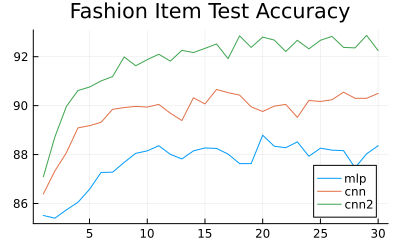

In [7]:
Plots.gr(size=(400,250))
label = ["mlp" "cnn" "cnn2"]
title = "Fashion Item Test Accuracy"
Plots.plot(1:epochs, accuracies, label=label, title=title)

숫자 손글씨 분류

In [8]:
function get_mnist_data(batchsize = 64)
    xtrain, ytrain = MLDatasets.MNIST(:train)[:]
    xtest, ytest = MLDatasets.MNIST(:test)[:]

    xtrain = reshape(xtrain, 28, 28, 1, :)
    xtest = reshape(xtest, 28, 28, 1, :)

    ytrain, ytest = onehotbatch(ytrain, 0:9), onehotbatch(ytest, 0:9)

    train_loader = DataLoader((xtrain, ytrain), batchsize=batchsize)
    test_loader = DataLoader((xtest, ytest),  batchsize=batchsize)
    
    return train_loader, test_loader
end

get_mnist_data (generic function with 2 methods)

In [9]:
rng = MersenneTwister(1)
models = [build_mlp_model(rng), build_cnn_model(rng), build_cnn2_model(rng)] 
models = models .|> Flux.gpu

epochs = 30
train_losses, accuracies = run_batch(get_mnist_data(), models, epochs);

[Model 1] Epoch 1
-------------------------------


[Train] loss: 0.0820082 [300/938]


[Train] loss: 0.1160886 [600/938]


[Train] loss: 0.0680300 [900/938]


[Test] Accuracy: 95.4, Avg loss: 0.1427165
[Model 1] Epoch 2
-------------------------------


[Train] loss: 0.0271692 [300/938]


[Train] loss: 0.0274327 [600/938]


[Train] loss: 0.0402313 [900/938]
[Test] Accuracy: 97.0, Avg loss: 0.0973027
[Model 1] Epoch 3
-------------------------------


[Train] loss: 0.0197965 [300/938]


[Train] loss: 0.0284775 [600/938]


[Train] loss: 0.0135472 [900/938]


[Test] Accuracy: 97.4, Avg loss: 0.0951010
[Model 1] Epoch 4
-------------------------------


[Train] loss: 0.0125373 [300/938]


[Train] loss: 0.0158667 [600/938]


[Train] loss: 0.0152917 [900/938]


[Test] Accuracy: 97.6, Avg loss: 0.0940651
[Model 1] Epoch 5
-------------------------------


[Train] loss: 0.0088648 [300/938]


[Train] loss: 0.0214824 [600/938]


[Train] loss: 0.0103437 [900/938]


[Test] Accuracy: 97.0, Avg loss: 0.1207490
[Model 1] Epoch 6
-------------------------------


[Train] loss: 0.0012515 [300/938]


[Train] loss: 0.0114243 [600/938]


[Train] loss: 0.0083054 [900/938]


[Test] Accuracy: 97.4, Avg loss: 0.1085491
[Model 1] Epoch 7
-------------------------------


[Train] loss: 0.0036581 [300/938]


[Train] loss: 0.0123424 [600/938]


[Train] loss: 0.0002169 [900/938]


[Test] Accuracy: 97.8, Avg loss: 0.0991519
[Model 1] Epoch 8
-------------------------------


[Train] loss: 0.0057217 [300/938]


[Train] loss: 0.0030862 [600/938]


[Train] loss: 0.0009393 [900/938]


[Test] Accuracy: 97.6, Avg loss: 0.1045473
[Model 1] Epoch 9
-------------------------------


[Train] loss: 0.0002703 [300/938]


[Train] loss: 0.0221862 [600/938]


[Train] loss: 0.0120440 [900/938]


[Test] Accuracy: 97.9, Avg loss: 0.0997867
[Model 1] Epoch 10
-------------------------------


[Train] loss: 0.0030339 [300/938]


[Train] loss: 0.0053669 [600/938]


[Train] loss: 0.0011808 [900/938]


[Test] Accuracy: 98.0, Avg loss: 0.1007948
[Model 1] Epoch 11
-------------------------------


[Train] loss: 0.0008088 [300/938]


[Train] loss: 0.0002806 [600/938]


[Train] loss: 0.0055374 [900/938]
[Test] Accuracy: 97.9, Avg loss: 0.1103610
[Model 1] Epoch 12
-------------------------------


[Train] loss: 0.0002539 [300/938]


[Train] loss: 0.0042093 [600/938]


[Train] loss: 0.0025949 [900/938]


[Test] Accuracy: 98.1, Avg loss: 0.0956654
[Model 1] Epoch 13
-------------------------------


[Train] loss: 0.0034006 [300/938]


[Train] loss: 0.0008943 [600/938]


[Train] loss: 0.0001334 [900/938]


[Test] Accuracy: 98.0, Avg loss: 0.1137056
[Model 1] Epoch 14
-------------------------------


[Train] loss: 0.0016800 [300/938]


[Train] loss: 0.0016414 [600/938]


[Train] loss: 0.0000387 [900/938]


[Test] Accuracy: 97.9, Avg loss: 0.1222898
[Model 1] Epoch 15
-------------------------------


[Train] loss: 0.0001579 [300/938]


[Train] loss: 0.0004509 [600/938]


[Train] loss: 0.0000323 [900/938]


[Test] Accuracy: 97.9, Avg loss: 0.1145826
[Model 1] Epoch 16
-------------------------------


[Train] loss: 0.0001821 [300/938]


[Train] loss: 0.0021195 [600/938]


[Train] loss: 0.0007679 [900/938]
[Test] Accuracy: 98.1, Avg loss: 0.1049492
[Model 1] Epoch 17
-------------------------------


[Train] loss: 0.0001194 [300/938]


[Train] loss: 0.0229301 [600/938]


[Train] loss: 0.0003392 [900/938]


[Test] Accuracy: 98.2, Avg loss: 0.1090548
[Model 1] Epoch 18
-------------------------------


[Train] loss: 0.0007881 [300/938]


[Train] loss: 0.0008378 [600/938]


[Train] loss: 0.0011347 [900/938]
[Test] Accuracy: 98.2, Avg loss: 0.1246955
[Model 1] Epoch 19
-------------------------------


[Train] loss: 0.0000491 [300/938]


[Train] loss: 0.0002524 [600/938]


[Train] loss: 0.0007155 [900/938]


[Test] Accuracy: 98.2, Avg loss: 0.1102720
[Model 1] Epoch 20
-------------------------------


[Train] loss: 0.0004206 [300/938]


[Train] loss: 0.0002093 [600/938]


[Train] loss: 0.0002038 [900/938]
[Test] Accuracy: 98.2, Avg loss: 0.1175207
[Model 1] Epoch 21
-------------------------------


[Train] loss: 0.0000172 [300/938]


[Train] loss: 0.0004877 [600/938]


[Train] loss: 0.0012201 [900/938]


[Test] Accuracy: 97.9, Avg loss: 0.1439737
[Model 1] Epoch 22
-------------------------------


[Train] loss: 0.0001797 [300/938]


[Train] loss: 0.0069769 [600/938]


[Train] loss: 0.0038177 [900/938]


[Test] Accuracy: 97.9, Avg loss: 0.1567518
[Model 1] Epoch 23
-------------------------------


[Train] loss: 0.0009874 [300/938]


[Train] loss: 0.0000030 [600/938]


[Train] loss: 0.0014269 [900/938]
[Test] Accuracy: 98.1, Avg loss: 0.1391597
[Model 1] Epoch 24
-------------------------------


[Train] loss: 0.0001421 [300/938]


[Train] loss: 0.0005877 [600/938]


[Train] loss: 0.0000044 [900/938]


[Test] Accuracy: 98.1, Avg loss: 0.1413388
[Model 1] Epoch 25
-------------------------------


[Train] loss: 0.0000842 [300/938]


[Train] loss: 0.0003745 [600/938]


[Train] loss: 0.0016031 [900/938]


[Test] Accuracy: 98.0, Avg loss: 0.1652516
[Model 1] Epoch 26
-------------------------------


[Train] loss: 0.0019737 [300/938]


[Train] loss: 0.0002653 [600/938]


[Train] loss: 0.0003083 [900/938]


[Test] Accuracy: 97.9, Avg loss: 0.1508589
[Model 1] Epoch 27
-------------------------------


[Train] loss: 0.0170786 [300/938]


[Train] loss: 0.0002405 [600/938]


[Train] loss: 0.0008414 [900/938]


[Test] Accuracy: 98.2, Avg loss: 0.1242845
[Model 1] Epoch 28
-------------------------------


[Train] loss: 0.0001315 [300/938]


[Train] loss: 0.0003258 [600/938]


[Train] loss: 0.0000159 [900/938]


[Test] Accuracy: 97.8, Avg loss: 0.1696828
[Model 1] Epoch 29
-------------------------------


[Train] loss: 0.0000198 [300/938]


[Train] loss: 0.0000558 [600/938]


[Train] loss: 0.0001229 [900/938]


[Test] Accuracy: 98.3, Avg loss: 0.1228206
[Model 1] Epoch 30
-------------------------------


[Train] loss: 0.0000002 [300/938]


[Train] loss: 0.0001423 [600/938]


[Train] loss: 0.0001595 [900/938]
[Test] Accuracy: 98.3, Avg loss: 0.1466310
[Model 2] Epoch 1
-------------------------------


[Train] loss: 0.0552377 [300/938]


[Train] loss: 0.1056270 [600/938]


[Train] loss: 0.0278910 [900/938]


[Test] Accuracy: 97.9, Avg loss: 0.0639577
[Model 2] Epoch 2
-------------------------------


[Train] loss: 0.0137520 [300/938]


[Train] loss: 0.0765771 [600/938]


[Train] loss: 0.0042647 [900/938]


[Test] Accuracy: 98.6, Avg loss: 0.0421275
[Model 2] Epoch 3
-------------------------------


[Train] loss: 0.0055539 [300/938]


[Train] loss: 0.0377581 [600/938]


[Train] loss: 0.0288356 [900/938]


[Test] Accuracy: 98.7, Avg loss: 0.0360033
[Model 2] Epoch 4
-------------------------------


[Train] loss: 0.0020655 [300/938]


[Train] loss: 0.0302144 [600/938]


[Train] loss: 0.0053056 [900/938]


[Test] Accuracy: 98.8, Avg loss: 0.0380295
[Model 2] Epoch 5
-------------------------------


[Train] loss: 0.0095294 [300/938]


[Train] loss: 0.0224579 [600/938]


[Train] loss: 0.0030347 [900/938]


[Test] Accuracy: 99.0, Avg loss: 0.0319974
[Model 2] Epoch 6
-------------------------------


[Train] loss: 0.0027820 [300/938]


[Train] loss: 0.0078472 [600/938]


[Train] loss: 0.0022210 [900/938]


[Test] Accuracy: 98.9, Avg loss: 0.0400510
[Model 2] Epoch 7
-------------------------------


[Train] loss: 0.0004876 [300/938]


[Train] loss: 0.0086745 [600/938]


[Train] loss: 0.0061160 [900/938]


[Test] Accuracy: 99.0, Avg loss: 0.0369918
[Model 2] Epoch 8
-------------------------------


[Train] loss: 0.0071451 [300/938]


[Train] loss: 0.0412397 [600/938]


[Train] loss: 0.0011289 [900/938]


[Test] Accuracy: 98.9, Avg loss: 0.0374692
[Model 2] Epoch 9
-------------------------------


[Train] loss: 0.0018928 [300/938]


[Train] loss: 0.0123151 [600/938]


[Train] loss: 0.0008114 [900/938]


[Test] Accuracy: 99.1, Avg loss: 0.0313842
[Model 2] Epoch 10
-------------------------------


[Train] loss: 0.0000326 [300/938]


[Train] loss: 0.0050185 [600/938]


[Train] loss: 0.0004126 [900/938]


[Test] Accuracy: 99.2, Avg loss: 0.0332434
[Model 2] Epoch 11
-------------------------------


[Train] loss: 0.0036536 [300/938]


[Train] loss: 0.0025933 [600/938]


[Train] loss: 0.0002972 [900/938]


[Test] Accuracy: 98.4, Avg loss: 0.0675097
[Model 2] Epoch 12
-------------------------------


[Train] loss: 0.0023720 [300/938]


[Train] loss: 0.0009476 [600/938]


[Train] loss: 0.0023879 [900/938]


[Test] Accuracy: 98.8, Avg loss: 0.0538853
[Model 2] Epoch 13
-------------------------------


[Train] loss: 0.0020407 [300/938]


[Train] loss: 0.0013769 [600/938]


[Train] loss: 0.0038031 [900/938]


[Test] Accuracy: 98.9, Avg loss: 0.0482554
[Model 2] Epoch 14
-------------------------------


[Train] loss: 0.0000755 [300/938]


[Train] loss: 0.0018769 [600/938]


[Train] loss: 0.0001719 [900/938]


[Test] Accuracy: 98.8, Avg loss: 0.0491414
[Model 2] Epoch 15
-------------------------------


[Train] loss: 0.0003782 [300/938]


[Train] loss: 0.0034086 [600/938]


[Train] loss: 0.0000670 [900/938]


[Test] Accuracy: 99.0, Avg loss: 0.0538782
[Model 2] Epoch 16
-------------------------------


[Train] loss: 0.0025528 [300/938]


[Train] loss: 0.0021433 [600/938]


[Train] loss: 0.0000132 [900/938]


[Test] Accuracy: 99.0, Avg loss: 0.0489538
[Model 2] Epoch 17
-------------------------------


[Train] loss: 0.0023724 [300/938]


[Train] loss: 0.0355636 [600/938]


[Train] loss: 0.0000202 [900/938]


[Test] Accuracy: 99.1, Avg loss: 0.0452395
[Model 2] Epoch 18
-------------------------------


[Train] loss: 0.0009706 [300/938]


[Train] loss: 0.0064206 [600/938]


[Train] loss: 0.0000195 [900/938]


[Test] Accuracy: 99.1, Avg loss: 0.0434916
[Model 2] Epoch 19
-------------------------------


[Train] loss: 0.0043171 [300/938]


[Train] loss: 0.0003433 [600/938]


[Train] loss: 0.0003077 [900/938]


[Test] Accuracy: 99.3, Avg loss: 0.0310110
[Model 2] Epoch 20
-------------------------------


[Train] loss: 0.0000532 [300/938]


[Train] loss: 0.0000991 [600/938]


[Train] loss: 0.0004570 [900/938]


[Test] Accuracy: 99.0, Avg loss: 0.0601984
[Model 2] Epoch 21
-------------------------------


[Train] loss: 0.0004630 [300/938]


[Train] loss: 0.0024349 [600/938]


[Train] loss: 0.0007781 [900/938]


[Test] Accuracy: 99.0, Avg loss: 0.0441235
[Model 2] Epoch 22
-------------------------------


[Train] loss: 0.0001244 [300/938]


[Train] loss: 0.0016573 [600/938]


[Train] loss: 0.0000127 [900/938]


[Test] Accuracy: 99.2, Avg loss: 0.0394833
[Model 2] Epoch 23
-------------------------------


[Train] loss: 0.0000143 [300/938]


[Train] loss: 0.0009004 [600/938]


[Train] loss: 0.0000471 [900/938]


[Test] Accuracy: 99.2, Avg loss: 0.0416476
[Model 2] Epoch 24
-------------------------------


[Train] loss: 0.0000131 [300/938]


[Train] loss: 0.0078758 [600/938]


[Train] loss: 0.0003927 [900/938]


[Test] Accuracy: 98.7, Avg loss: 0.0639090
[Model 2] Epoch 25
-------------------------------


[Train] loss: 0.0011443 [300/938]


[Train] loss: 0.0003670 [600/938]


[Train] loss: 0.0001358 [900/938]


[Test] Accuracy: 99.1, Avg loss: 0.0527051
[Model 2] Epoch 26
-------------------------------


[Train] loss: 0.0000051 [300/938]


[Train] loss: 0.0024191 [600/938]


[Train] loss: 0.0000020 [900/938]


[Test] Accuracy: 99.1, Avg loss: 0.0554861
[Model 2] Epoch 27
-------------------------------


[Train] loss: 0.0000205 [300/938]


[Train] loss: 0.0002235 [600/938]


[Train] loss: 0.0000012 [900/938]


[Test] Accuracy: 99.2, Avg loss: 0.0427780
[Model 2] Epoch 28
-------------------------------


[Train] loss: 0.0000904 [300/938]


[Train] loss: 0.0030888 [600/938]


[Train] loss: 0.0000533 [900/938]


[Test] Accuracy: 99.2, Avg loss: 0.0467389
[Model 2] Epoch 29
-------------------------------


[Train] loss: 0.0000009 [300/938]


[Train] loss: 0.0003054 [600/938]


[Train] loss: 0.0000022 [900/938]


[Test] Accuracy: 99.4, Avg loss: 0.0373542
[Model 2] Epoch 30
-------------------------------


[Train] loss: 0.0005994 [300/938]


[Train] loss: 0.0002708 [600/938]


[Train] loss: 0.0004521 [900/938]


[Test] Accuracy: 99.3, Avg loss: 0.0530009
[Model 3] Epoch 1
-------------------------------


[Train] loss: 0.1683601 [300/938]


[Train] loss: 0.1691645 [600/938]


[Train] loss: 0.0828119 [900/938]


[Test] Accuracy: 98.5, Avg loss: 0.0430672
[Model 3] Epoch 2
-------------------------------


[Train] loss: 0.0349134 [300/938]


[Train] loss: 0.0563884 [600/938]


[Train] loss: 0.0558616 [900/938]


[Test] Accuracy: 98.9, Avg loss: 0.0305265
[Model 3] Epoch 3
-------------------------------


[Train] loss: 0.0376776 [300/938]


[Train] loss: 0.0798392 [600/938]


[Train] loss: 0.0172015 [900/938]


[Test] Accuracy: 99.1, Avg loss: 0.0273849
[Model 3] Epoch 4
-------------------------------


[Train] loss: 0.0364499 [300/938]


[Train] loss: 0.1927637 [600/938]


[Train] loss: 0.0298406 [900/938]


[Test] Accuracy: 99.2, Avg loss: 0.0239075
[Model 3] Epoch 5
-------------------------------


[Train] loss: 0.0121050 [300/938]


[Train] loss: 0.0536984 [600/938]


[Train] loss: 0.0383173 [900/938]


[Test] Accuracy: 99.1, Avg loss: 0.0285372
[Model 3] Epoch 6
-------------------------------


[Train] loss: 0.0232825 [300/938]


[Train] loss: 0.2024473 [600/938]


[Train] loss: 0.0102809 [900/938]


[Test] Accuracy: 99.3, Avg loss: 0.0241018
[Model 3] Epoch 7
-------------------------------


[Train] loss: 0.0078458 [300/938]


[Train] loss: 0.1839282 [600/938]


[Train] loss: 0.0092757 [900/938]


[Test] Accuracy: 99.4, Avg loss: 0.0189806
[Model 3] Epoch 8
-------------------------------


[Train] loss: 0.0174149 [300/938]


[Train] loss: 0.0316078 [600/938]


[Train] loss: 0.0035570 [900/938]


[Test] Accuracy: 99.4, Avg loss: 0.0203945
[Model 3] Epoch 9
-------------------------------


[Train] loss: 0.0041265 [300/938]


[Train] loss: 0.0428124 [600/938]


[Train] loss: 0.0079649 [900/938]


[Test] Accuracy: 99.4, Avg loss: 0.0221899
[Model 3] Epoch 10
-------------------------------


[Train] loss: 0.0101862 [300/938]


[Train] loss: 0.0330454 [600/938]


[Train] loss: 0.0142551 [900/938]


[Test] Accuracy: 99.3, Avg loss: 0.0224900
[Model 3] Epoch 11
-------------------------------


[Train] loss: 0.0051055 [300/938]


[Train] loss: 0.1715382 [600/938]


[Train] loss: 0.0096281 [900/938]


[Test] Accuracy: 99.4, Avg loss: 0.0198665
[Model 3] Epoch 12
-------------------------------


[Train] loss: 0.0209879 [300/938]


[Train] loss: 0.0699965 [600/938]


[Train] loss: 0.0201634 [900/938]


[Test] Accuracy: 99.4, Avg loss: 0.0209203
[Model 3] Epoch 13
-------------------------------


[Train] loss: 0.0005109 [300/938]


[Train] loss: 0.0905974 [600/938]


[Train] loss: 0.0139214 [900/938]


[Test] Accuracy: 99.3, Avg loss: 0.0244746
[Model 3] Epoch 14
-------------------------------


[Train] loss: 0.0024963 [300/938]


[Train] loss: 0.0345888 [600/938]


[Train] loss: 0.0047252 [900/938]


[Test] Accuracy: 99.3, Avg loss: 0.0236852
[Model 3] Epoch 15
-------------------------------


[Train] loss: 0.0142306 [300/938]


[Train] loss: 0.0409479 [600/938]


[Train] loss: 0.0022100 [900/938]


[Test] Accuracy: 99.3, Avg loss: 0.0240332
[Model 3] Epoch 16
-------------------------------


[Train] loss: 0.0083993 [300/938]


[Train] loss: 0.0358176 [600/938]


[Train] loss: 0.0247452 [900/938]


[Test] Accuracy: 99.3, Avg loss: 0.0221444
[Model 3] Epoch 17
-------------------------------


[Train] loss: 0.0003061 [300/938]


[Train] loss: 0.0534871 [600/938]


[Train] loss: 0.0206319 [900/938]


[Test] Accuracy: 99.4, Avg loss: 0.0218283
[Model 3] Epoch 18
-------------------------------


[Train] loss: 0.0106136 [300/938]


[Train] loss: 0.0722530 [600/938]


[Train] loss: 0.0218400 [900/938]


[Test] Accuracy: 99.4, Avg loss: 0.0223099
[Model 3] Epoch 19
-------------------------------


[Train] loss: 0.0036776 [300/938]


[Train] loss: 0.1618994 [600/938]


[Train] loss: 0.0028073 [900/938]


[Test] Accuracy: 99.4, Avg loss: 0.0227243
[Model 3] Epoch 20
-------------------------------


[Train] loss: 0.0051480 [300/938]


[Train] loss: 0.0254690 [600/938]


[Train] loss: 0.0493241 [900/938]


[Test] Accuracy: 99.4, Avg loss: 0.0199312
[Model 3] Epoch 21
-------------------------------


[Train] loss: 0.0007515 [300/938]


[Train] loss: 0.0363308 [600/938]


[Train] loss: 0.0551525 [900/938]


[Test] Accuracy: 99.3, Avg loss: 0.0229213
[Model 3] Epoch 22
-------------------------------


[Train] loss: 0.0018297 [300/938]


[Train] loss: 0.0199163 [600/938]


[Train] loss: 0.0453751 [900/938]


[Test] Accuracy: 99.4, Avg loss: 0.0220376
[Model 3] Epoch 23
-------------------------------


[Train] loss: 0.0023341 [300/938]


[Train] loss: 0.0034217 [600/938]


[Train] loss: 0.0114765 [900/938]


[Test] Accuracy: 99.3, Avg loss: 0.0261481
[Model 3] Epoch 24
-------------------------------


[Train] loss: 0.0030324 [300/938]


[Train] loss: 0.0520646 [600/938]


[Train] loss: 0.0025728 [900/938]


[Test] Accuracy: 99.4, Avg loss: 0.0233297
[Model 3] Epoch 25
-------------------------------


[Train] loss: 0.0055913 [300/938]


[Train] loss: 0.0860361 [600/938]


[Train] loss: 0.0250930 [900/938]


[Test] Accuracy: 99.5, Avg loss: 0.0215913
[Model 3] Epoch 26
-------------------------------


[Train] loss: 0.0018469 [300/938]


[Train] loss: 0.0206904 [600/938]


[Train] loss: 0.0096168 [900/938]


[Test] Accuracy: 99.5, Avg loss: 0.0224864
[Model 3] Epoch 27
-------------------------------


[Train] loss: 0.0149141 [300/938]


[Train] loss: 0.0361035 [600/938]


[Train] loss: 0.0176250 [900/938]


[Test] Accuracy: 99.4, Avg loss: 0.0242934
[Model 3] Epoch 28
-------------------------------


[Train] loss: 0.0017345 [300/938]


[Train] loss: 0.0417796 [600/938]


[Train] loss: 0.0083321 [900/938]


[Test] Accuracy: 99.4, Avg loss: 0.0238546
[Model 3] Epoch 29
-------------------------------


[Train] loss: 0.0041727 [300/938]


[Train] loss: 0.0988949 [600/938]


[Train] loss: 0.0006025 [900/938]


[Test] Accuracy: 99.4, Avg loss: 0.0221535
[Model 3] Epoch 30
-------------------------------


[Train] loss: 0.0004724 [300/938]


[Train] loss: 0.0050017 [600/938]


[Train] loss: 0.0003492 [900/938]


[Test] Accuracy: 99.4, Avg loss: 0.0209738


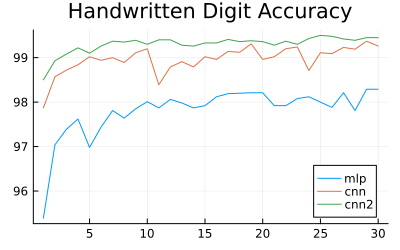

In [10]:
Plots.gr(size=(400,250))
label = ["mlp" "cnn" "cnn2"]
title = "Handwritten Digit Accuracy"
Plots.plot(1:epochs, accuracies, label=label, title=title)